In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import numpy as onp
import jax
import jax.numpy as np

from jax import lax, random
from jax.api import grad, jit, vmap
from jax.config import config
from jax.experimental import optimizers
from jax.experimental.stax import logsoftmax

config.update('jax_enable_x64', True)

from neural_tangents import stax

from functools import partial

# Attacking
from cleverhans.utils import clip_eta, one_hot

# Plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *

sns.set_style(style='white')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

"""
diag_reg:
    a scalar representing the strength of the diagonal regularization for
    `k_train_train`, i.e. computing `k_train_train + diag_reg * I` during
    Cholesky factorization or eigendecomposition.
"""
diag_reg = 1e-5

# data

In [2]:
DATASET = 'cifar10'
class_num   = 10
image_shape = None

train_size = 4096
valid_size = 512
test_size = 128

batch_size = 256
eps = 0.03
epochs = 1000

if DATASET =='mnist':
    image_shape = (28, 28, 1)
elif DATASET == 'cifar10':
    image_shape = (32, 32, 3)

In [3]:
x_train_all, y_train_all, x_test_all, y_test_all = tuple(onp.array(x) for x in get_dataset(DATASET, None, None, 
                                                                                  do_flatten_and_normalize=False))

In [4]:
# shuffle
seed = 0
x_train_all, y_train_all = shaffle(x_train_all, y_train_all, seed)

In [5]:
# down sample
x_train = x_train_all[:train_size]
y_train = y_train_all[:train_size]

x_valid = x_train_all[train_size:train_size + valid_size]
y_valid = y_train_all[train_size:train_size + valid_size]

x_test = x_test_all[:test_size]
y_test = y_test_all[:test_size]

In [6]:
x_train, x_valid, x_test = x_train.reshape((-1, *image_shape)), x_valid.reshape((-1, *image_shape)), x_test.reshape((-1, *image_shape))

# model

In [7]:
def correct(mean, ys):
    return onp.argmax(mean, axis=-1) == onp.argmax(ys, axis=-1)

In [8]:
def ConvBlock(channels, W_std, b_std, strides=(1,1)):
    return stax.serial(stax.Conv(out_chan=channels, filter_shape=(3,3), strides=strides, padding='SAME',
                                 W_std=W_std, b_std=b_std), 
                       stax.Relu(do_backprop=True))

def ConvGroup(n, channels, stride, W_std, b_std, last_stride=False):
    blocks = []
    if last_stride:
        for i in range(n-1):
            blocks += [ConvBlock(channels, W_std, b_std, stride)]
        blocks += [ConvBlock(channels, W_std, b_std, (2, 2))]
    
    else:
        for i in range(n):
            blocks += [ConvBlock(channels, W_std, b_std, stride)]
        
    return stax.serial(*blocks)
        
def VGG19_stride(class_num=class_num):
    
    return stax.serial(
        ConvGroup(n=2, channels=64 , stride=(1,1), W_std=0.1, b_std=0.18, last_stride=True),
        ConvGroup(n=2, channels=128, stride=(1,1), W_std=0.1, b_std=0.18, last_stride=True),
        ConvGroup(n=4, channels=256, stride=(1,1), W_std=0.1, b_std=0.18, last_stride=True),
        ConvGroup(n=4, channels=512, stride=(1,1), W_std=0.1, b_std=0.18, last_stride=True),
        ConvGroup(n=4, channels=512, stride=(1,1), W_std=0.1, b_std=0.18, last_stride=True),
        stax.Flatten(),
        stax.Dense(4096), stax.Relu(do_backprop=True),
        stax.Dense(4096), stax.Relu(do_backprop=True),
        stax.Dense(class_num))

def simple_net(class_num=class_num):
    return stax.serial(
        ConvGroup(n=3, channels=64 , stride=(1,1), W_std=onp.sqrt(2), b_std=0.0, last_stride=False),
        stax.Flatten(),
        stax.Dense(256, W_std=onp.sqrt(2), b_std=0.0), stax.Relu(do_backprop=True),
        stax.Dense(class_num, W_std=onp.sqrt(2), b_std=0.0))

In [9]:
init_fn, apply_fn, kernel_fn = simple_net(class_num)

In [10]:
apply_fn = jit(apply_fn)

In [11]:
key = random.PRNGKey(88888)
key, net_key = random.split(key)
_, params = init_fn(net_key, (-1, 32, 32, 3))

In [12]:
learning_rate = 0.01
# training_steps = 3200

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

In [13]:
loss = jit(lambda params, x, y: 0.5 * np.mean((apply_fn(params, x) - y) ** 2))
grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

In [14]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = onp.random.permutation(len(a))
    return a[p], b[p]

In [15]:
opt_state = opt_init(params)

In [18]:
onp.std(params[0][0][0][0])

DeviceArray(0.9993765, dtype=float64)

In [16]:
train_losses = []
train_accuracy = []

valid_losses = []
valid_accuracy = []

valid = (x_valid, y_valid)

for i in range(epochs):
    train_epoch_losses = []
    train_epoch_accuracy = []
    
    valid_epoch_losses = []
    valid_epoch_accuracy = []
    
    for batch in range(train_size//batch_size):
        
        train = (x_train[batch*batch_size:batch*batch_size+batch_size], 
                 y_train[batch*batch_size:batch*batch_size+batch_size])
        
        opt_state = opt_update(i*(train_size//batch_size) + batch, grad_loss(opt_state, *train), opt_state)
        
        train_epoch_losses.append(loss(get_params(opt_state), *train))
        valid_epoch_losses.append(loss(get_params(opt_state), *valid))
        
        train_correctness = onp.argmax(apply_fn(get_params(opt_state), train[0]), 1) == onp.argmax(train[1], 1)
        train_epoch_accuracy.append(onp.average(train_correctness))
        
        valid_correctness = onp.argmax(apply_fn(get_params(opt_state), valid[0]), 1) == onp.argmax(valid[1], 1)
        valid_epoch_accuracy.append(onp.average(valid_correctness))
    
    print("epoch %3d: train loss %3.5f, valid loss %3.5f train acc %.5f valid acc %.5f"%\
          (i, onp.average(train_epoch_losses), 
           onp.average(valid_epoch_losses), 
           onp.average(train_epoch_accuracy), 
           onp.average(valid_epoch_accuracy)))
    
    train_losses.append(onp.average(train_epoch_losses))
    train_accuracy.append(onp.average(train_epoch_accuracy))
    
    valid_losses.append(onp.average(valid_epoch_losses))
    valid_accuracy.append(onp.average(valid_epoch_accuracy))
    
    x_train, y_train = unison_shuffled_copies(x_train, y_train)

epoch   0: train loss 0.22954, valid loss 0.21737 train acc 0.08960 valid acc 0.10083
epoch   1: train loss 0.22033, valid loss 0.20867 train acc 0.09009 valid acc 0.09961
epoch   2: train loss 0.21187, valid loss 0.20075 train acc 0.08984 valid acc 0.09888
epoch   3: train loss 0.20408, valid loss 0.19336 train acc 0.09033 valid acc 0.09766
epoch   4: train loss 0.19690, valid loss 0.18662 train acc 0.08960 valid acc 0.09656
epoch   5: train loss 0.19028, valid loss 0.18042 train acc 0.09009 valid acc 0.09570
epoch   6: train loss 0.18417, valid loss 0.17466 train acc 0.09033 valid acc 0.09570
epoch   7: train loss 0.17849, valid loss 0.16933 train acc 0.09058 valid acc 0.09509
epoch   8: train loss 0.17321, valid loss 0.16436 train acc 0.09033 valid acc 0.09766
epoch   9: train loss 0.16827, valid loss 0.15971 train acc 0.09058 valid acc 0.09766
epoch  10: train loss 0.16366, valid loss 0.15535 train acc 0.09033 valid acc 0.09766
epoch  11: train loss 0.15933, valid loss 0.15129 trai

epoch  96: train loss 0.06924, valid loss 0.06681 train acc 0.07959 valid acc 0.10938
epoch  97: train loss 0.06902, valid loss 0.06661 train acc 0.07983 valid acc 0.11023
epoch  98: train loss 0.06880, valid loss 0.06641 train acc 0.07983 valid acc 0.11279
epoch  99: train loss 0.06858, valid loss 0.06621 train acc 0.07959 valid acc 0.11279
epoch 100: train loss 0.06837, valid loss 0.06602 train acc 0.07959 valid acc 0.11133
epoch 101: train loss 0.06817, valid loss 0.06583 train acc 0.07959 valid acc 0.11133
epoch 102: train loss 0.06796, valid loss 0.06564 train acc 0.08032 valid acc 0.11133
epoch 103: train loss 0.06776, valid loss 0.06546 train acc 0.07935 valid acc 0.11133
epoch 104: train loss 0.06757, valid loss 0.06528 train acc 0.07935 valid acc 0.10950
epoch 105: train loss 0.06738, valid loss 0.06511 train acc 0.07959 valid acc 0.10938
epoch 106: train loss 0.06719, valid loss 0.06494 train acc 0.08008 valid acc 0.10876
epoch 107: train loss 0.06700, valid loss 0.06477 trai

epoch 192: train loss 0.05837, valid loss 0.05698 train acc 0.08325 valid acc 0.10547
epoch 193: train loss 0.05832, valid loss 0.05693 train acc 0.08350 valid acc 0.10547
epoch 194: train loss 0.05826, valid loss 0.05688 train acc 0.08325 valid acc 0.10645
epoch 195: train loss 0.05821, valid loss 0.05684 train acc 0.08325 valid acc 0.10742


KeyboardInterrupt: 

In [17]:
onp.sqrt(2/(3*3*3))

0.2721655269759087

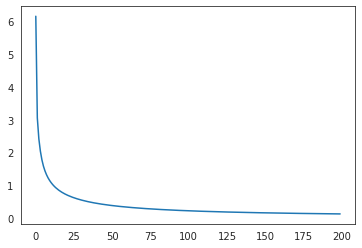

In [34]:
plt.plot(range(200), train_losses)

In [17]:
correctness = onp.argmax(apply_fn(get_params(opt_state), x_train), 1) == onp.argmax(y_train, 1)

In [21]:
onp.average(correctness)

0.08203125

# loss

In [14]:
@jit
def l2_loss_v1(logits, labels, weighting=1):
    """
    Tensorflow version of L2 loss (without sqrt)
    """
    return np.sum(((logits - labels)**2) * weighting) / 2
    
@jit
def l2_loss_v2(logits, lables):
    """
    Normal L2 loss
    """
    return np.linalg.norm(logits - labels)

@jit
def cross_entropy_loss(logits, lables):
    return -np.sum(logsoftmax(logits) * lables)
    
@jit
def mse_loss(logits, lables):
    return 0.5 * np.mean((logits - lables) ** 2)

# attack algorithms

In [15]:
def fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, x_train=None, y_train=None, x_test=None, 
                         y=None, t=None, loss_weighting=None, fx_train_0=0., fx_test_0=0., eps=0.3, 
                         norm=np.inf, clip_min=None, clip_max=None, targeted=False):
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
        
    # test independent
    if obj_fn == 'untargeted':
        grads = grads_fn(x_train, x_test, y_train, y, kernel_fn, t)
        
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

    axis = list(range(1, len(grads.shape)))
    eps_div = 1e-12
    
    if norm == np.inf:
        perturbation = eps * np.sign(grads)
    elif norm == 1:
        raise NotImplementedError("L_1 norm has not been implemented yet.")
    elif norm == 2:
        square = np.maximum(eps_div, np.sum(np.square(grads), axis=axis, keepdims=True))
        perturbation = grads / np.sqrt(square)
    
    # TODO
    adv_x = x + perturbation
    
    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        # We don't currently support one-sided clipping
        assert clip_min is not None and clip_max is not None
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    
    return adv_x

In [16]:
def iter_fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, x_train=None, y_train=None,
                               x_test=None, y=None, t=None, loss_weighting=None, fx_train_0=0., fx_test_0=0., 
                               eps=0.3, eps_iter=0.03, nb_iter=10, norm=np.inf, clip_min=None, clip_max=None, 
                               targeted=False, rand_init=None, rand_minmax=0.3):
    assert eps_iter <= eps, (eps_iter, eps)
    if norm == 1:
        raise NotImplementedError("It's not clear that FGM is a good inner loop"
                                  " step for PGD when norm=1, because norm=1 FGM "
                                  " changes only one pixel at a time. We need "
                                  " to rigorously test a strong norm=1 PGD "
                                  "before enabling this feature.")
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
    
    # Initialize loop variables
    if rand_init:
        rand_minmax = eps
        eta = random.uniform(new_key, x.shape, minval=-rand_minmax, maxval=rand_minmax)
    else:
        eta = np.zeros_like(x)

    # Clip eta
    eta = clip_eta(eta, norm, eps)
    adv_x = x + eta
    if clip_min is not None or clip_max is not None:
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
        
    for i in range(nb_iter):
        adv_x = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, x_train, y_train, adv_x, 
                                        y, t, loss_weighting, fx_train_0, fx_test_0, eps_iter, norm, 
                                        clip_min, clip_max, targeted)

        # Clipping perturbation eta to norm norm ball
        eta = adv_x - x
        eta = clip_eta(eta, norm, eps)
        adv_x = x + eta

        # Redo the clipping.
        # FGM already did it, but subtracting and re-adding eta can add some
        # small numerical error.
        if clip_min is not None or clip_max is not None:
            adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    
    return adv_x

# Attack Hyperparameters

In [17]:
if DATASET == 'mnist':
    eps = 0.3
    eps_iter_10 = (eps/10)*1.1
    eps_iter_100 = (eps/100)*1.1
    eps_iter_1000 = (eps/1000)*1.1
    
elif DATASET == 'cifar10':
    eps = 0.03
    eps_iter_10 = (eps/10)*1.1
    eps_iter_100 = (eps/100)*1.1

In [18]:
def evaluate_accuracy(x_train, x_test, y_test, model_fn, kernel_fn, t=None, attack_type=None, ntk_train_train=None):
    
    y_train_predict, y_test_predict = model_fn(kernel_fn, x_train, x_test, 
                                               t=t, ntk_train_train=ntk_train_train)
    
    selected_table = correct(y_test_predict, y_test)
    print("Accuray({:s}): {:.2f}".format(attack_type, onp.mean(selected_table)))
    
    return selected_table

In [19]:
def evaluate_robustness(x_train, x_test, y_test, model_fn, kernel_fn, selected_table, t=None, 
                        attack_type=None, ntk_train_train=None):
    
    y_train_predict, y_test_predict = model_fn(kernel_fn, x_train, x_test,
                                               t=t, ntk_train_train=ntk_train_train)
    
    y_test_predict = onp.asarray(y_test_predict)
    y_test_predict_select = y_test_predict[onp.asarray(selected_table)]
    y_test_select = y_test[onp.asarray(selected_table)]
    print("Robustness({:s}): {:.2f}".format(attack_type, onp.mean(correct(y_test_predict_select, y_test_select))))
    
    return

# adv_x generation